# Mask Detection Demo
The following example demonstrates an end-to-end data science workflow for building an image classifier model.<br/>
The model is trained on a dataset containing images of people with or without masks.<br/>
The model is then deployed to a Nuclio function allowing users to send an http request with an image and receive a 
response back with the probability that the person in the image is wearing a mask.

## Key Technologies
- [**Tensorflow-Keras**](https://www.tensorflow.org/api_docs/python/tf/keras) to train the model
- [**Horovod**](https://horovod.ai/) to run distributed training
- [**Nuclio**](https://nuclio.io/) to create a high-performance serverless Serving function
- [**MLRun**](https://www.mlrun.org/) to orchestrate the process

### Set up the Project and Environment
Create a new project, set the environment and create the paths where we'll store the project's artifacts:

In [1]:
import mlrun
import os

project_name='mask-detection'
project_dir = os.path.abspath('./')
project = mlrun.new_project(project_name, project_dir)
mlrun.set_environment(project=project.metadata.name)
artifact_path = mlrun.mlconf.artifact_path

code_dir = project_dir
dataset_path = os.path.join(project_dir, 'dataset') 
model_path = os.path.join(project_dir,'models')
code_dir, dataset_path, model_path

('/home/jovyan/data/mask-detection',
 '/home/jovyan/data/mask-detection/dataset',
 '/home/jovyan/data/mask-detection/models')

### Import the Dataset
[The MLRun functions marketplace](https://github.com/mlrun/functions/) (a.k.a. "the MLRun functions hub") is a 
centralized location for open-source contributions of function components that are commonly used in machine learning 
development.

This step uses the [Open archive marketplace function](https://github.com/mlrun/functions/tree/master/open_archive), 
which opens a remote zip archive into a local folder.

In [2]:
open_archive_function = mlrun.import_function('hub://open_archive:development')

**Run the Function**

Note that we're setting the `local` param to `True` which means the function code will run locally inside the jupyter 
kernel. Alternatively, we could set it to `False` (the default), in which case MLRun would automatically spawn a k8s pod
and run the function inside it, allowing us to isolate the function running environment and use our k8s cluster 
resources.

In [3]:
open_archive_function.apply(mlrun.platforms.auto_mount())
open_archive_function.run(handler='open_archive', 
                          params={'target_path' : dataset_path}, 
                          inputs={"archive_url": "https://s3.wasabisys.com/iguazio/data/mask-detection/Dataset.zip"},
                          local=True)

> 2021-05-11 15:02:48,669 [info] starting run open-archive-open_archive uid=317dad445bea4b999dbc6f365cf6dba6 DB=http://mlrun-api:8080
> 2021-05-11 15:02:48,737 [info] downloading https://s3.wasabisys.com/iguazio/data/mask-detection/Dataset.zip to local tmp


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mask-detection,...5cf6dba6,0,May 11 15:02:48,completed,open-archive-open_archive,kind=owner=jovyanhost=mlrun-kit-jupyter-58bf8855bf-nwjg2,archive_url,target_path=/home/jovyan/data/mask-detection/dataset,,content


to track results use .show() or .logs() or in CLI: 
!mlrun get run 317dad445bea4b999dbc6f365cf6dba6 --project mask-detection , !mlrun logs 317dad445bea4b999dbc6f365cf6dba6 --project mask-detection
> 2021-05-11 15:04:18,328 [info] run executed, status=completed


### Train the Model
The training code is basically the same as the code from [the kaggle project](https://www.kaggle.com/notadithyabhat/face-mask-detector/execution) 
with slight changes to allow us to use Horovod to do distributed training (more info [here](https://docs.mlrun.org/en/latest/runtimes/horovod.html)). 
The original training code can be found [here](training_code_original.py).

Roughly, the changes I made to the training code were:
- Code at the beginning to extract job params from MLRun context
- Code to initialize Horovod and assign devices (CPU/GPU) before building the model
- Replace to use the Horovod optimizer
- Code at the end to log the results to MLRun DB

In the following code sample, you can start to see **the value of MLRun**: with a simple value change, you can 
**distribute** your model **training** across **multiple workers** (i.e., perform distributed training), assign **GPUs**, 
and more. You don't need to bother with Dockerfiles or K8s YAML configuration files — MLRun does all of this for you.

In [4]:
gpus = 0
epochs = 5
replicas = 1
batch_size = 16

image = 'mlrun/ml-models-gpu' if gpus else 'mlrun/ml-models'

code_file = os.path.join(code_dir, 'training_code.py')
trainer = mlrun.new_function(name='trainer',
                             kind='mpijob',
                             command=code_file,
                             image=image)

trainer.spec.replicas = replicas

trainer.apply(mlrun.platforms.auto_mount())

if gpus:
    trainer.gpus(gpus)

**Running the Function** <br/>
Every function execution in MLRun is recorded in an object called **Run**, which enables us a good **tracking** of what
we did: the **function inputs, outputs, logs, etc.** This lets us play with the different configurations, and later on 
examine which one was the best. Attached screenshot is from the MLRun UI, showing the history of the experiments, 
allowing you to compare the different runs, rerun them, monitor them and much more...

In [5]:
trainer.run(params={'epochs'         : epochs,
                    'batch_size'     : batch_size,
                    'images'         : dataset_path + '/images',
                    'annotations'    : dataset_path + '/annotations',
                    'model_artifacts': model_path})

> 2021-05-11 15:07:23,230 [info] starting run trainer uid=d64289304bfc48b19e426e7f27b506e7 DB=http://mlrun-api:8080
> 2021-05-11 15:07:33,375 [info] MpiJob trainer-6d4ea409 launcher pod trainer-6d4ea409-launcher state active
+ POD_NAME=trainer-6d4ea409-worker-0
+ shift
+ /opt/kube/kubectl exec trainer-6d4ea409-worker-0 -- /bin/sh -c        PATH=/usr/local/bin:$PATH ; export PATH ; LD_LIBRARY_PATH=/usr/local/lib:$LD_LIBRARY_PATH ; export LD_LIBRARY_PATH ; DYLD_LIBRARY_PATH=/usr/local/lib:$DYLD_LIBRARY_PATH ; export DYLD_LIBRARY_PATH ;   /usr/local/bin/orted -mca ess "env" -mca ess_base_jobid "2312568832" -mca ess_base_vpid 1 -mca ess_base_num_procs "2" -mca orte_node_regex "trainer-[1:6]d4ea409-launcher,trainer-[1:6]d4ea409-worker-0@0(2)" -mca orte_hnp_uri "2312568832.0;tcp://10.1.2.100:38389" -mca plm "rsh" --tree-spawn -mca routed "radix" -mca orte_parent_uri "2312568832.0;tcp://10.1.2.100:38389" -mca plm_rsh_agent "/etc/mpi/kubexec.sh" -mca orte_default_hostfile "/etc/mpi/hostfile" -

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mask-detection,...27b506e7,0,May 11 15:07:40,completed,trainer,kind=mpijobowner=jovyanmlrun/job=trainer-6d4ea409host=trainer-6d4ea409-worker-0,,epochs=5batch_size=16images=/home/jovyan/data/mask-detection/dataset/imagesannotations=/home/jovyan/data/mask-detection/dataset/annotationsmodel_artifacts=/home/jovyan/data/mask-detection/modelsimage_width=224image_height=224image_channels=3random_state=1test_size=0.3,loss=0.7377297878265381accuracy=0.6904761791229248,summary.htmlmodel-weightsmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run d64289304bfc48b19e426e7f27b506e7 --project mask-detection , !mlrun logs d64289304bfc48b19e426e7f27b506e7 --project mask-detection
> 2021-05-11 15:09:01,051 [info] run executed, status=completed


<img src="MLRun-ui-screenshot.png">

### Deploying the Model

This time we're using the [tensorflow v2 serving function](https://github.com/mlrun/functions/tree/master/tf2_serving) 
from the hub.
The serving function kind is using [Nuclio](https://github.com/nuclio/nuclio/): a high-performance serverless event 
and data processing open-source platform.
With just a few lines of code we can take our model, **expose** it with an **http endpoint** and deploy it on 
**high-performance** infrastructure that can easily scale up to serve on a **production environment** with hundreds of 
thousands of requests per second.

In [6]:
serving_function = mlrun.import_function('hub://tf2_serving_v2:development')
serving_function.apply(mlrun.platforms.auto_mount())
serving_function.add_model('mask-detection-model', model_path, class_name='TFModel')
function_envs = {
    'IMAGE_HEIGHT': 224,
    'IMAGE_WIDTH': 224,
}
serving_function.set_envs(function_envs)

In [7]:
serving_function.deploy()

> 2021-05-11 15:09:10,460 [info] Starting remote function deploy
2021-05-11 15:09:10  (info) Deploying function
2021-05-11 15:09:10  (info) Building
2021-05-11 15:09:10  (info) Staging files and preparing base images
2021-05-11 15:09:10  (info) Building processor image
2021-05-11 15:09:22  (info) Build complete
2021-05-11 15:09:36  (info) Function deploy complete
> 2021-05-11 15:09:37,411 [info] function deployed, address=192.168.65.4:31960


'http://192.168.65.4:31960'

### Using the Model
Here's a demonstration how to send an image to our serving function API, and see the model's prediction of the 
probability that the people in the image are wearing a mask.

In [8]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

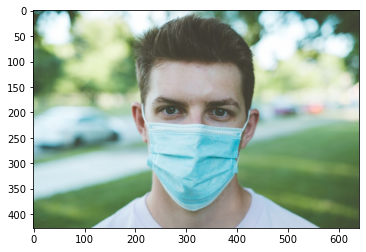

In [9]:
image_url = 'https://unsplash.com/photos/hB_gwZCEIfs/download?force=true&w=640'
response = requests.get(image_url)
plt.imshow(Image.open(BytesIO(response.content)))

In [10]:
path = 'v2/models/mask-detection-model/predict'
serving_address = f'http://nuclio-{project.metadata.name}-{serving_function.metadata.name}:8080/{path}'

response = requests.post(url=serving_address, json={"data_url" : image_url})
response_body = response.json()
print(f"""
mask weared incorrectly probability: {response_body['outputs'][0]}
with mask probability: {response_body['outputs'][1]}
without mask probability: {response_body['outputs'][2]}
""")


mask weared incorrectly probability: 0.0973595345020294
with mask probability: 0.8526288318634033
without mask probability: 0.050011624321341515



## Saving Time and Effort
It’s a very exciting time to be working in machine learning, because there are so many great use cases that are just 
waiting to be productized. Operationalizing a data science project can balloon in complexity, fast. That’s why planning 
an MLOps strategy is a critical initial stage. The right framework--MLRun in this case--can be a force multiplier, 
enabling you to take existing training code and quickly build it into a full production-ready application. With just 
200 lines of code, we were able to distribute our training, track our trials, and deploy our final model on 
production-scale infrastructure.
 
MLRun has even more to offer, like function versioning, experiment tracking, feature store, automatic pipeline 
scheduling, model monitoring and more. 

We invite you to join our upcoming global virtual Hackathon for Good, where ML teams will compete to build ML solutions
with a real-world impact.


### The author
Hedi Ingber is the main maintainer of MLRun. He's also a Backend Engineer at Iguazio, which offers the enterprise 
version of MLRun.
 